In [1]:
#| hide
%load_ext autoreload
%autoreload 2

In [2]:
from discontinuitypy.core.pipeline import ids_finder
from discontinuitypy.datasets import IDsDataset
from discontinuitypy.utils.basic import resample
import polars as pl
from beforerr.polars import pl_norm

from sunpy.time import TimeRange
from datetime import timedelta
import speasy as spz
from speasy import SpeasyVariable
from space_analysis.utils.speasy import Variables, spzvar2pldf

  File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/__init__.py", line 85, in <module>
    from . import skintegrate
  File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/skintegrate.py", line 20, in <module>
    from sklearn.base import BaseEstimator
ModuleNotFoundError: No module named 'sklearn'

  File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/__init__.py", line 105, in <module>
    from . import nltk_stages
  File "/Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/pdpipe/nltk_stages.py", line 19, in <module>
    import nltk
ModuleNotFoundError: No module named 'nltk'



In [5]:
start = '2019-04-06T12:00'
start = '2019-04-07T01:00'
end = '2019-04-07T12:00'

earth_start = '2019-04-09'
earth_end = '2019-04-14'

# tau = timedelta(seconds=60)
tau = timedelta(seconds=10)
ts = timedelta(seconds=1/264)

In [6]:
psp_timerange = TimeRange(start, end)
timerange_earth = TimeRange(earth_start, earth_end)

In [7]:
def validate(timerange):
    if isinstance(timerange, TimeRange):
        return [timerange.start.to_string(), timerange.end.to_string()]

In [9]:
psp_mag_data: spz.SpeasyVariable = spz.get_data(
    "cda/PSP_FLD_L2_MAG_RTN/psp_fld_l2_mag_RTN", validate(psp_timerange)
)
psp_mag_data = spzvar2pldf(psp_mag_data)

In [11]:
#| output: false
candidate = ids_finder(psp_mag_data, tau, ts)

04-Feb-24 17:45:34 WARNING  04-Feb-24 17:45:34: UserWarning: Distributing <class                      ]8;id=864964;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=484550;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py#205\205]8;;\
                            'pandas.core.frame.DataFrame'> object. This may take some time.                        
                                                                                                                   

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

In [12]:
psp_ids_dataset = IDsDataset(
    candidates = candidate,
    data = psp_mag_data
)

## Examples of discontinuities observed by PSP

2024-02-04 17:45:39.106 | INFO     | discontinuitypy.datasets:plot_candidates:67 - Candidates indices: [145, 90, 155, 142]


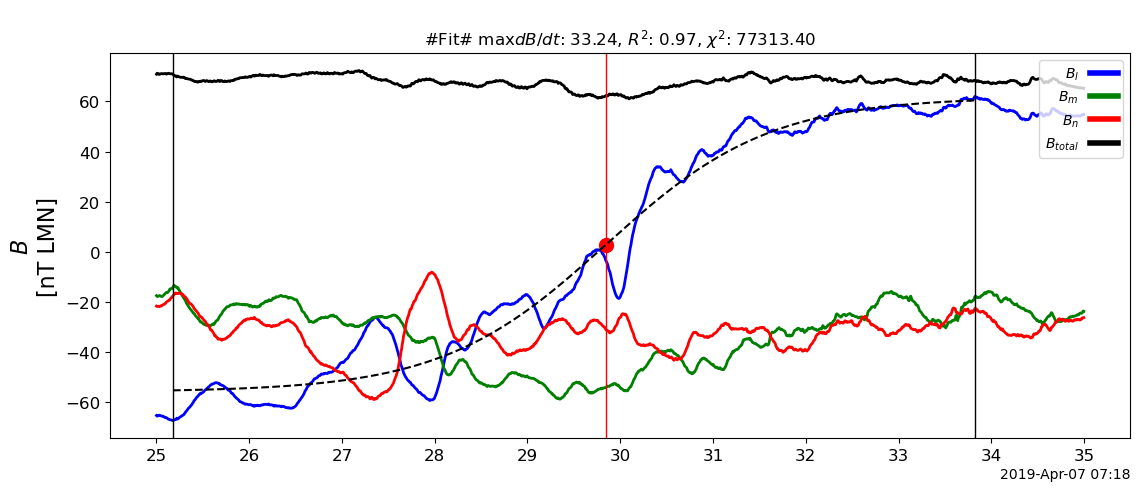

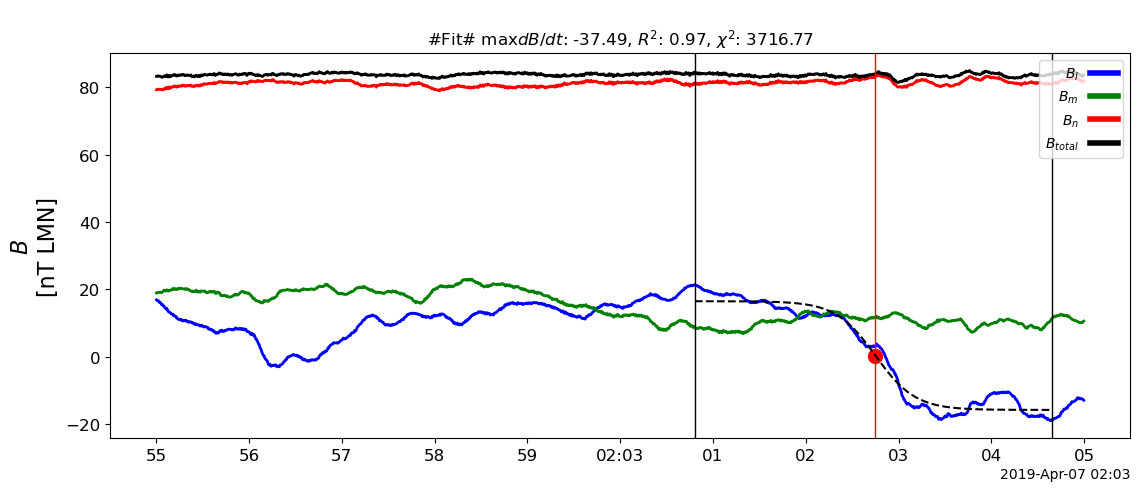

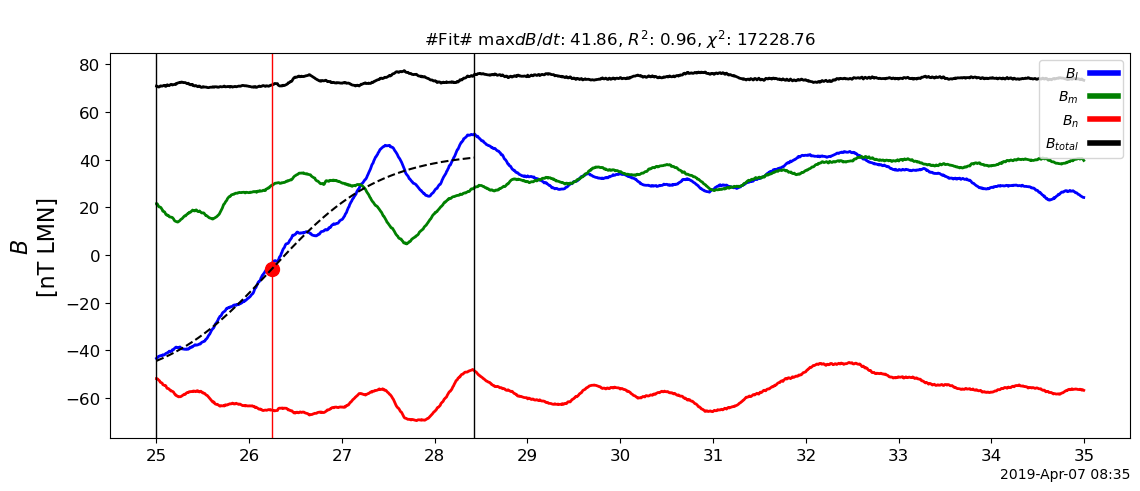

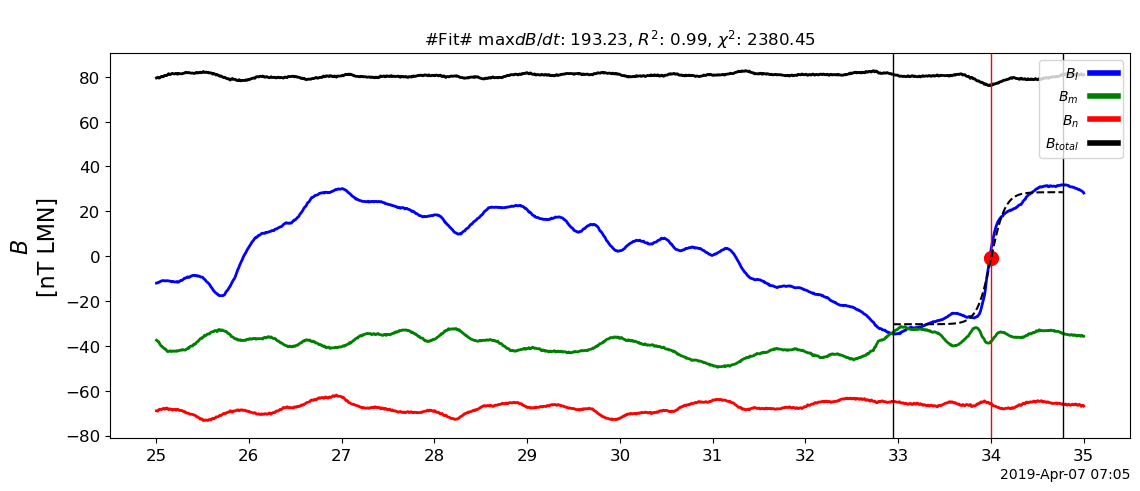

In [13]:
#| column: screen
#| layout-ncol: 3
outs = psp_ids_dataset.plot_candidates(plot_fit_data=True)

## Resampled dataset

By visually inspecting data, the most strong discontinuities kind of have time duration about 1-3 seconds. 
So it is reasonable to downsample the data to a lower frequency so that 

- the detection method is more robust, excluding very high frequency wave/noise?
- it is better to apply the derivative method to get the properties of the discontinuities.
- Match `Wind` time resolution.

Or we could fit the $B_l$ to get the properties of the discontinuities.

In [14]:
every = timedelta(seconds=1/11)
ts = timedelta(seconds=1/11)

data_r = resample(psp_mag_data, every)

In [15]:
candidates_r = ids_finder(data_r, tau, ts)

04-Feb-24 17:45:48 WARNING  04-Feb-24 17:45:48: DeprecationWarning: `pl.count()` is deprecated.       ]8;id=326893;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=306723;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py#205\205]8;;\
                            Please use `pl.len()` instead.                                                         
                                                                                                                   

                   WARNING  04-Feb-24 17:45:48: DeprecationWarning: `map_alias` is deprecated. It has ]8;id=136954;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=574254;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py#205\205]8;;\
                            been moved to `name.map`.                                                              
                                                                                                                   

                   WARNING  04-Feb-24 17:45:48: DeprecationWarning: `map_alias` is deprecated. It has ]8;id=732989;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=681879;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py#205\205]8;;\
                            been moved to `name.map`.                                                              
                                                                                                                   

04-Feb-24 17:45:49 WARNING  04-Feb-24 17:45:49: UserWarning: Distributing <class                      ]8;id=482771;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=450296;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py#205\205]8;;\
                            'pandas.core.frame.DataFrame'> object. This may take some time.                        
                                                                                                                   

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

In [20]:
dataset = "PSP_SWP_SPI_SF00_L3_MOM"
parameters = ["DENS", "VEL_RTN_SUN", "TEMP", "SUN_DIST"]

In [21]:
psp_plasma = Variables(
    dataset=dataset, parameters=parameters, timerange=validate(psp_timerange)
).get_data()

In [24]:
vec_cols = ["Vx RTN", "Vy RTN", "Vz RTN"]

psp_plasma_r = (
    psp_plasma.to_polars()
    .pipe(resample, every=tau)
    .with_columns(plasma_speed=pl_norm(vec_cols))
    .rename(
        {
            "Density": "plasma_density",
            "Temperature": "plasma_temperature",
        }
    )
)

In [25]:
psp_ids_dataset = IDsDataset(
    candidates = candidates_r,
    data = data_r,
    plasma_data = psp_plasma_r,
    vec_cols = vec_cols
)

psp_ids_dataset.update_candidates_with_plasma_data()

04-Feb-24 17:46:57 WARNING  04-Feb-24 17:46:57: PendingDeprecationWarning: The `dims` argument has    ]8;id=310008;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=72878;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py#205\205]8;;\
                            been renamed to `dim`, and will be removed in the future. This renaming                
                            is taking place throughout xarray over the next few releases.                          
                                                                                                                   

                   WARNING  04-Feb-24 17:46:57: PendingDeprecationWarning: The `dims` argument has    ]8;id=154297;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=55161;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py#205\205]8;;\
                            been renamed to `dim`, and will be removed in the future. This renaming                
                            is taking place throughout xarray over the next few releases.                          
                                                                                                                   

                   WARNING  04-Feb-24 17:46:57: PendingDeprecationWarning: The `dims` argument has    ]8;id=872237;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=476025;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py#205\205]8;;\
                            been renamed to `dim`, and will be removed in the future. This renaming                
                            is taking place throughout xarray over the next few releases.                          
                                                                                                                   

                   WARNING  04-Feb-24 17:46:57: DeprecationWarning: `nanoseconds` is deprecated. It   ]8;id=940053;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=223313;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py#205\205]8;;\
                            has been renamed to `total_nanoseconds`.                                               
                                                                                                                   

                   WARNING  04-Feb-24 17:46:57: DeprecationWarning: `nanoseconds` is deprecated. It   ]8;id=77111;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=19656;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py#205\205]8;;\
                            has been renamed to `total_nanoseconds`.                                               
                                                                                                                   

                   WARNING  04-Feb-24 17:46:57: DeprecationWarning: `nanoseconds` is deprecated. It   ]8;id=836664;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=243787;file:///Users/zijin/micromamba/envs/psp_conjunction/lib/python3.11/site-packages/astropy/logger.py#205\205]8;;\
                            has been renamed to `total_nanoseconds`.                                               
                                                                                                                   

In [26]:
def ids_filter(df: pl.DataFrame):
    return df.filter(
        pl.col('index_diff')>1, # interested in strong discontinuities
        pl.col('fit.stat.rsquared')>0.9, # interested in good fits
    )

2024-02-04 17:46:59.728 | INFO     | discontinuitypy.datasets:plot_candidates:67 - Candidates indices: [53, 35, 91, 1]


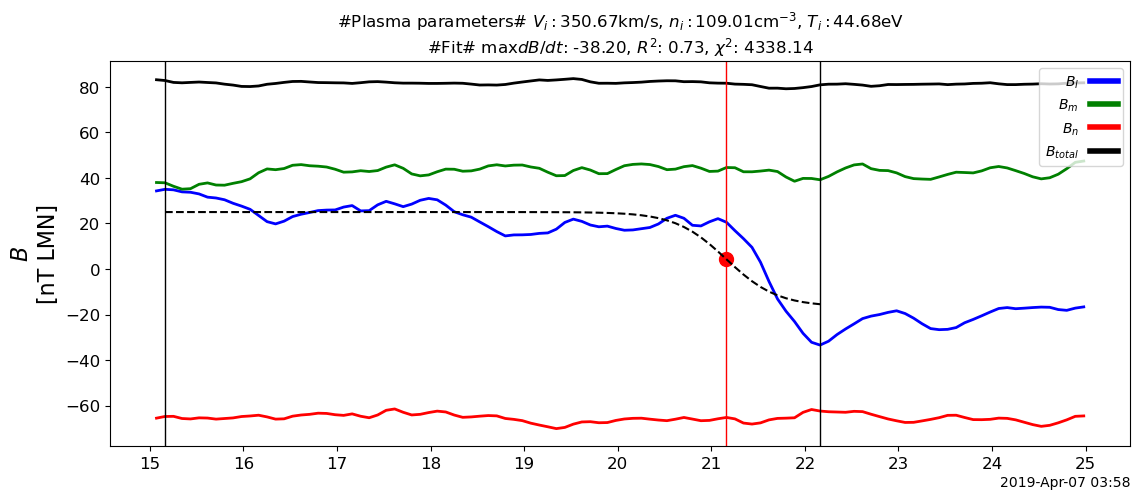

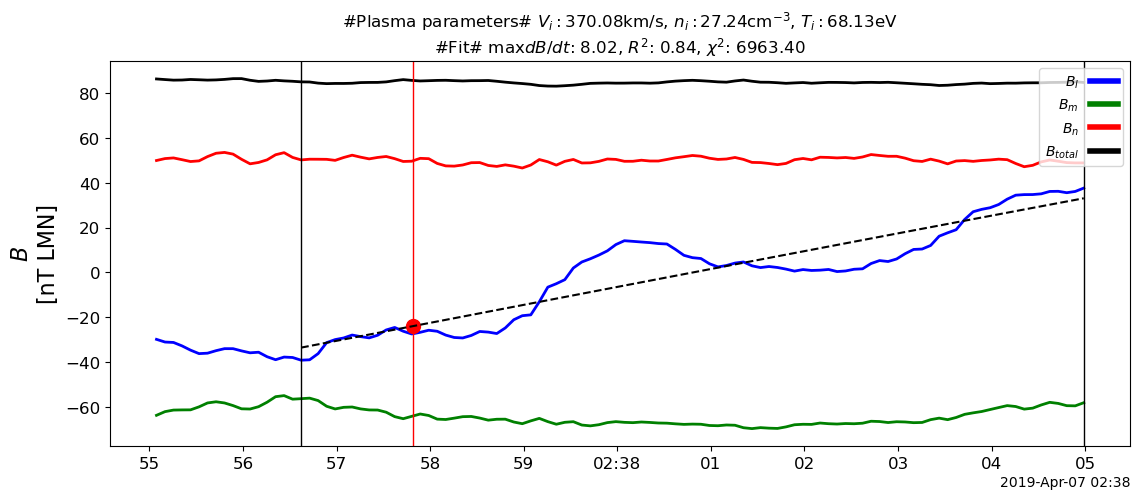

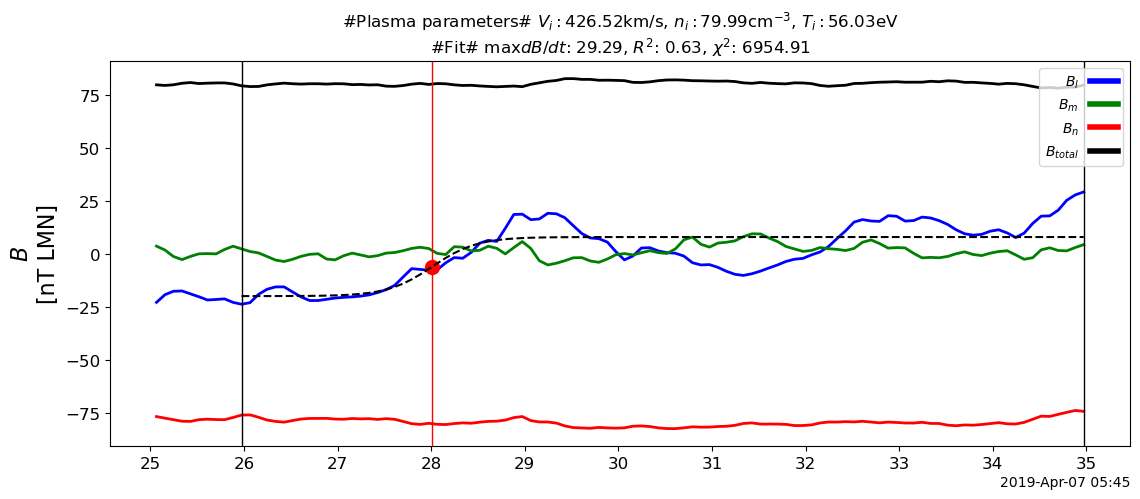

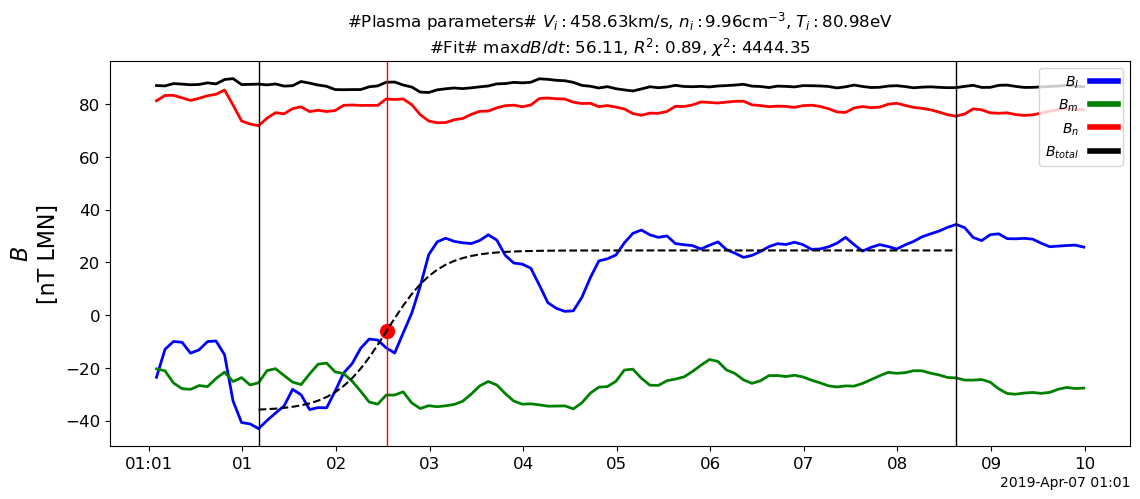

In [27]:
#| column: screen
#| layout-ncol: 3
outs = psp_ids_dataset.plot_candidates(add_plasma_params=True, plot_fit_data=True)